# Predicting monthly airline passenger volume

This dataset is from Jason Brownlee's book, 'Deep Learning for Time Series Forecasting'. The purpose of this analysis is to compare how various models perform on univariate time series data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
%matplotlib inline

In [2]:
#load data
def load_data():
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
    df = pd.read_csv(url, header = 0)
    return df

df = load_data()

In [3]:
#split into train and test
def train_test_split(df, train_length = 12):
    train_df = df.head(len(df) - train_length)
    test_df = df.tail(train_length)
    return train_df, test_df

train_df, test_df = train_test_split(df)

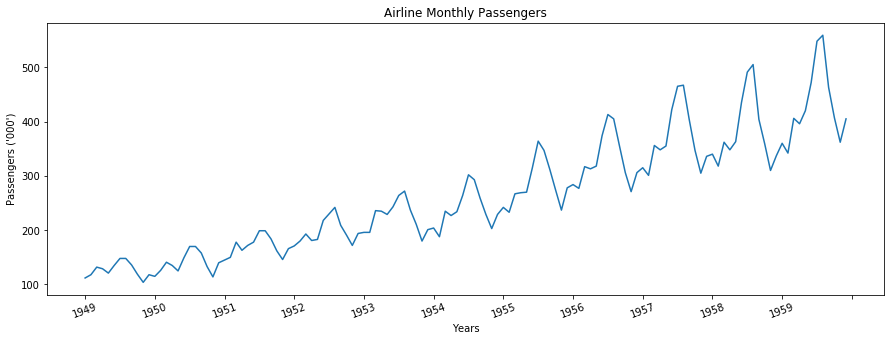

In [4]:
#plot
def plot_series(df, format = '-', start = 0, end = None):
    fig = plt.figure(figsize=(15, 5))
    plt.plot(df.Month, df.Passengers, format)
    plt.xlabel('Years')
    labels = [i for i in range(1949, 1960)]
    plt.xticks(np.arange(0, 133, step = 12), labels, rotation=20)
    plt.ylabel('Passengers (\'000\')')
    plt.title('Airline Monthly Passengers')
    plt.show()

plot_series(train_df)

In [5]:
#create windows
@tf.autograph.experimental.do_not_convert
def create_windows(series, shift = 1, window_length = 12, shuffle_buffer = 10, batch_size = 12):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size = window_length + 1, shift = shift, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
def define_model(model_type, input_shape = 12):
    
    if model_type == 'simple':
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(1, input_shape = [input_shape])
            ])
        
    if model_type == 'mlp':
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(50, activation = 'relu', input_shape = [input_shape]),
            tf.keras.layers.Dense(1)
        ])
        
    if model_type == 'cnn':
        model = tf.keras.models.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[12]),
            tf.keras.layers.Conv1D(32, 3, activation = 'relu'),
            tf.keras.layers.MaxPooling1D(),
            tf.keras.layers.Conv1D(32, 3, activation = 'relu'),
            tf.keras.layers.MaxPooling1D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1)
        ])
        
    if model_type == 'rnn':
        model = tf.keras.models.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                   input_shape=[input_shape]),
            tf.keras.layers.SimpleRNN(32, return_sequences=True),
          tf.keras.layers.SimpleRNN(32),
          tf.keras.layers.Dense(1),
          tf.keras.layers.Lambda(lambda x: x * 100.0)
        ])
        
    if model_type == 'lstm':
        model = tf.keras.models.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[input_shape]),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
            tf.keras.layers.Dense(1),
            tf.keras.layers.Lambda(lambda x: x * 100.0)
        ])
        
        
    model.compile(optimizer = 'adam',
                 loss = tf.keras.losses.Huber(),
                 metrics = ['mse'])
    
    return model


In [8]:
#predicting the passenger volume in the final year
def predict_last_year(model, df, window_length = 12):
    #creating a bucket to collect the forecasts
    forecast = []
    
    #feeding in the penultimate year, which will be used to predict the final year (test set)
    for time in range(12 * 10, 12 * 11):
        forecast.append(model.predict(np.array(df.Passengers[time: time + window_length]).reshape(([1, window_length]))))
    return forecast


In [9]:
def compile_scores(df, train_df, test_df):
    #creating a dictionary that will collect the error rate for the various models
    scores = {}
    
    plotting_df = test_df
    
    #list of models
    model_types = ['simple', 'mlp', 'cnn', 'rnn', 'lstm']
    
    
    for model_type in model_types:
        model = define_model(model_type)
        model.fit(create_windows(train_df.Passengers), epochs = 125, verbose = 0)
        forecast = predict_last_year(model, df)
        forecast = np.array(forecast).squeeze()
        plotting_df[model_type] = forecast
        error = tf.keras.metrics.mean_squared_error(forecast, np.array(test_df.Passengers)).numpy()
        scores[model_type] = error
    
    return scores, plotting_df

scores, plotting_df = compile_scores(df, train_df, test_df)

C:\Users\siddh\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


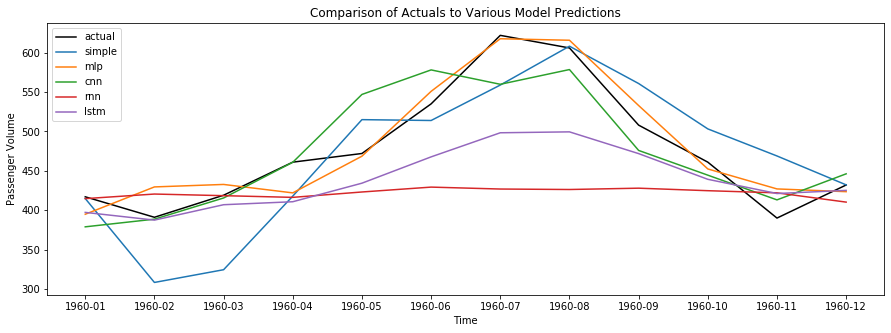

In [10]:
def plot_predictions(plotting_df):
    fig = plt.figure(figsize = (15, 5))
    plt.plot(plotting_df.Month, plotting_df.Passengers, c='black', label = 'actual')
    plt.plot(plotting_df.Month, plotting_df.simple, label = 'simple')
    plt.plot(plotting_df.Month, plotting_df.mlp, label = 'mlp')
    plt.plot(plotting_df.Month, plotting_df.cnn, label = 'cnn')
    plt.plot(plotting_df.Month, plotting_df.rnn, label = 'rnn')
    plt.plot(plotting_df.Month, plotting_df.lstm, label = 'lstm')
    plt.xlabel('Time')
    plt.ylabel('Passenger Volume')
    plt.title('Comparison of Actuals to Various Model Predictions')
    plt.legend(loc = 'upper left')
    plt.show()
    
plot_predictions(plotting_df)

In [11]:
scores

{'simple': 2896, 'mlp': 516, 'cnn': 1310, 'rnn': 8063, 'lstm': 3245}

**Conclusions**
The above scores and chart show that the MLP model had the minimum error (mean squared error). This is a surprising result. The MLP model chosen is fairly simple. I expected the long short-term memory model to have the minimum error, since that model is particularly well suited for time series.

The hyperparameters in these models are not tuned. Once tuned, the models showing the least error may differ.